# Some Algorithm

In this section we will see how to use some common Rigid Body Algorithms.

All those algorithm will use some the [MultiBodyConfig](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MultiBody.ipynb#MultiBodyConfig) member as input and output.

First we will see the:
 * [Forward Kinematic](#Forward-Kinematic)
 * [Forward Velocity](#Forward-Velocity)
 * [Forward Acceleration](#Forward-Acceleration)
 * [Inverse Dynamic](#Inverse-Dynamic)
 * [Forward Dynamic](#Forward-Dynamic)
 * [Euler Integration](#Euler-Integration)

In [1]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

viewer.scene.camera.focal_point = (0.138, 0.958, -0.205)
viewer.scene.camera.position = (3.763, 1.435, 4.453)

display_number = 1
def display():
    global display_number
    path = 'img/SomeAlgorithm/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

In [2]:
import numpy as np
import eigen3 as e
import spacevecalg as sva
import rbdyn as rbd

from robots import TutorialTree

print 'TutorialTree structure:'
print TutorialTree.__doc__

# create a robot with the same structure than the one in the MultiBody tutorial
mbg, mb, mbc = TutorialTree()

TutorialTree structure:

  Return the MultiBodyGraph, MultiBody and the zeroed MultiBodyConfig with the
  following tree structure:

                b4
             j3 | Spherical
  Root     j0   |   j1     j2     j4
  ---- b0 ---- b1 ---- b2 ----b3 ----b5
  Fixed    RevX   RevY    RevZ   PrismZ
  


In [3]:
# draw the robot
from graph import MultiBodyViz

# add visualization of the of the b4 and b5 body that don't have any successors
X_b4_ef = sva.PTransformd(sva.RotY(-np.pi/2.), e.Vector3d(0.2, 0., 0.))
X_b5_ef = sva.PTransformd(sva.RotX(-np.pi/2.), e.Vector3d(0., 0.2, 0.))
mbv = MultiBodyViz(mbg, mb, endEffectorDict={'b4':(X_b4_ef, 0.1, (1., 1., 0.)),
                                             'b5':(X_b5_ef, 0.1, (1., 1., 0.))})

mbv.addActors(viewer.scene)

## Forward Kinematic

We already see in the [MultiBody tutorial](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MultiBody.ipynb#MultiBodyConfig) the Forward Kinematic algorithm (FK).

This algorithm will compute the transformation of each body thanks to the articular position vector $ \mathbf{q} $.

Input:
 * q
 
Output:
 * jointConfig
 * parentToSon
 * bodyPosW

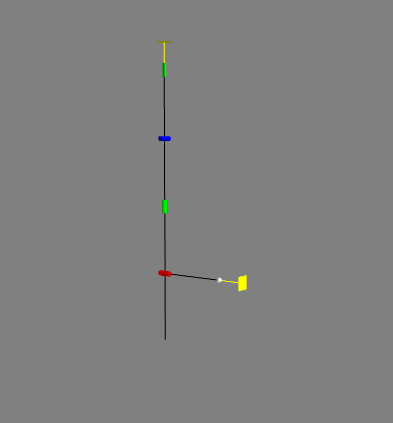

In [4]:
# run the forward kinematics with q = 0
rbd.forwardKinematics(mb, mbc)

# display the result
mbv.display(mb, mbc)
display()

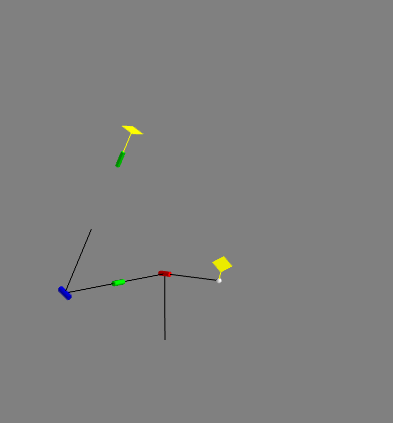

In [5]:
# Change the articular configuration q
q = map(list, mbc.q)
quat = e.Quaterniond(np.pi/3., e.Vector3d(0.1, 0.5, 0.3).normalized())

mbc.q = [[],
         [np.pi/2.],
         [np.pi/3.],
         [-np.pi/2.],
         [0.5],
         [quat.w(), quat.x(), quat.y(), quat.z()]]

rbd.forwardKinematics(mb, mbc)

# display the result
mbv.display(mb, mbc)
display()

## Forward Velocity

The Forward Velocity algorithm (FV) allow to compute the velocity of each body thanks to the articular velocity vector $ \mathbf{\alpha} $ and the result of the Forward Kinematic.

Input:
 * alpha
 * jointConfig
 * parentToSon
 * bodyPosW
 
Output:
 * jointVelocity
 * motionSubspace
 * bodyVelB
 * bodyVelW

Even if you just plan to make some inverse kinematics and don't need any velocity information you probably need to call this method **one** time.
This is because this method fill the **motionSubsace** vector which is **constant** like say in the [previous tutorial](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/MultiBody.ipynb#Joint).

alpha: [[], [0.0], [0.0], [0.0], [0.0], [0.0, 0.0, 0.0]]


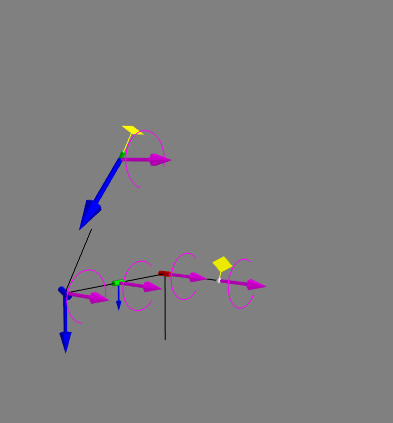

In [6]:
alpha = map(list, mbc.alpha)

print 'alpha:', alpha

alpha[1] = [0.4] # first revolute joint will turn at 0.4 radian per second

mbc.alpha = alpha
rbd.forwardVelocity(mb, mbc)
from graph import MotionVecViz
velocityVecV = [MotionVecViz(V, X) for X, V in zip(mbc.bodyPosW, mbc.bodyVelB)]

for v in velocityVecV:
    v.addActors(viewer.scene)
    
display()

In [7]:
for v in velocityVecV:
    v.removeActors(viewer.scene)

## Forward Acceleration

The Forward Acceleration algorithm (FA) compute the acceleration of each body (normal and tangential) thanks to the articular acceleration vector $ \dot{\mathbf{\alpha}} $ and the result of the Forward Kinematics and Forward Velocity.

Input:
 * alphaD
 * parentToSon
 * jointVelocity
 * bodyVelB
 * \[A_0\] the initial acceleration (not in MultiBodyConfig)
 
Output:
 * bodyAccB
 
The A_0 MotionVecd is the initial acceleration. This is usefull in some algorithm (Inverse Dynamic Identification Model) to compute the acceleration that need to achive the system to compensate the gravity.

Some algorithm will compute bodyAccB with or without gravity compensation, it will be precise each time.

alphaD: [[], [0.0], [0.0], [0.0], [0.0], [0.0, 0.0, 0.0]]
No gravity compensation


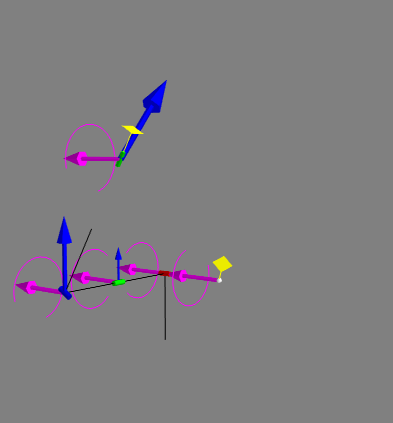

In [8]:
alphaD = map(list, mbc.alphaD)

print 'alphaD:', alphaD

alphaD[1] = [-0.5] # first revolute joint will turn is deceleration at -1 radian per second^2

mbc.alphaD = alphaD
rbd.forwardAcceleration(mb, mbc) # no gravity compensation
accelVecV = [MotionVecViz(V, X) for X, V in zip(mbc.bodyPosW, mbc.bodyAccB)]

for v in accelVecV:
    v.addActors(viewer.scene)
    
print 'No gravity compensation'
display()

In [9]:
for v in accelVecV:
    v.removeActors(viewer.scene)

gravity:      0      0      0      0 0.4905      0
with gravity compensation


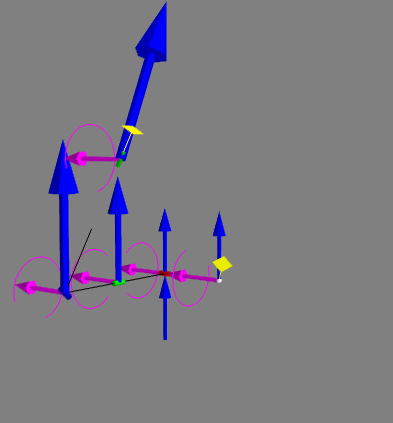

In [10]:
# we lower the default gravity because of display issues...
gravity = sva.MotionVecd(e.Vector3d.Zero(), mbc.gravity)*0.05

print 'gravity:', gravity
rbd.forwardAcceleration(mb, mbc, gravity) # with gravity compensation
accelVecV = [MotionVecViz(V, X) for X, V in zip(mbc.bodyPosW, mbc.bodyAccB)]

for v in accelVecV:
    v.addActors(viewer.scene)
    
print "with gravity compensation"
display()

In [11]:
for v in accelVecV:
    v.removeActors(viewer.scene)

## Inverse Dynamic

The Inverse Dynamic algorithm (ID) compute the articular torque vector $ \mathbf{\tau} $ that will produce an articular  acceleration vector $ \dot{\mathbf{\alpha}} $ given in input. It need also the result of the Forward Kinematics and Forward Velocity.

Input:
 * alphaD
 * force
 * jointConfig
 * parentToSon
 * bodyPosW
 * jointVelocity
 * bodyVelB
 * motionSubspace
 * gravity
 
Output:
  * bodyAccB (with gravity compensation)
  * jointTorque

Let's run this algorithm to know the amount of torque that need each joint to compensate the gravity and the achieve a zero motion.

In [12]:
# mbcID keep the mbc q vector but have a zero alpha and alphaD vector
mbcID = rbd.MultiBodyConfig(mb)
mbcID.zero(mb)
mbcID.q = mbc.q

rbd.forwardKinematics(mb, mbcID)
rbd.forwardVelocity(mb, mbcID)
ID = rbd.InverseDynamics(mb)
ID.inverseDynamics(mb, mbcID)

jointTorque = map(list, mbcID.jointTorque)
print 'jointTorque:', jointTorque

jointTorque: [[], [-24.525], [4.905000000000001], [8.047710038720992e-17], [8.495709211125343], [0.0, 0.0, 0.0]]


## Forward Dynamic

The Forward Dynamic (FD) algorithm do the reverse of the Inverse Dynamic. Given an articular acceleration vector $ \dot{\mathbf{\alpha}} $ it compute the articular torque vector $ \mathbf{\tau} $ that produce it. It need also the result of the Forward Kinematics and Forward Velocity.

Input:
 * jointTorque
 * force
 * parentToSon
 * bodyPosW
 * jointVelocity
 * bodyVelB
 * motionSubspace
 * gravity
 
Output:
 * alphaD
 * $ H \in \mathbb{R}^{A,A} $ the inertia matrix of the system
 * $ C \in \mathbb{R}^{A} $ the bias vector of the system

This algorithm solve the following equation $ H\dot{\mathbf{\alpha}} + C = \mathbf{\tau} $.

It's possible to only compute the $ H $ and $ C $ matrix.

In [13]:
# use the result of the ID to check if the acceleration computed
# by the FD are compatible with the ID torque.
mbcFD = rbd.MultiBodyConfig(mbcID)

FD = rbd.ForwardDynamics(mb)
FD.forwardDynamics(mb, mbcFD)

alphaDID = map(list, mbcID.alphaD)
alphaDFD = map(list, mbcFD.alphaD)

print 'input torque:', map(list, mbcFD.jointTorque)
print
print 'alphaDID:', alphaDID
print 'alphaDFD:', alphaDFD

alphaDIDVec = e.toNumpy(rbd.dofToVector(mb, alphaDID))
alphaDFDVec = e.toNumpy(rbd.dofToVector(mb, alphaDFD))
print 'residual:', np.linalg.norm(alphaDIDVec - alphaDFDVec)

input torque: [[], [-24.525], [4.905000000000001], [8.047710038720992e-17], [8.495709211125343], [0.0, 0.0, 0.0]]

alphaDID: [[], [0.0], [0.0], [0.0], [0.0], [0.0, 0.0, 0.0]]
alphaDFD: [[], [0.0], [0.0], [0.0], [0.0], [0.0, 0.0, 0.0]]
residual: 0.0


## Euler Integration



The Euler Integration algorithm used euler integration to make joint position and velocity evolve.

Basically this algorithm do the following:
$$
\mathbf{q}_{t+1} = \mathbf{q}_{t} + \mathbf{\alpha}_{t} \Delta_{dt}\\
\mathbf{\alpha}_{t+1} = \mathbf{\alpha}_{t} + \dot{\mathbf{\alpha}}_{t} \Delta_{dt}
$$
Where $ \Delta_{dt} $ is the integration step.

It's a little more tricky than that since some joint don't have the same vector size for their position vector and velocity vector. Also some joint position and velocity vector are not in the same frame.

Let's see what happened on our robot if we give a 0 torque vector has input.

In [14]:
mbcEI = rbd.MultiBodyConfig(mb)
mbcEI.zero(mb)
mbcEI.q = mbc.q

mbcList = []

iterations = 100
timeStep = 0.01

for i in xrange(iterations):
    rbd.forwardKinematics(mb, mbcEI)
    rbd.forwardVelocity(mb, mbcEI)
    FD.forwardDynamics(mb, mbcEI)
    mbcList.append(rbd.MultiBodyConfig(mbcEI)) # store the robot state
    
    rbd.eulerIntegration(mb, mbcEI, timeStep)

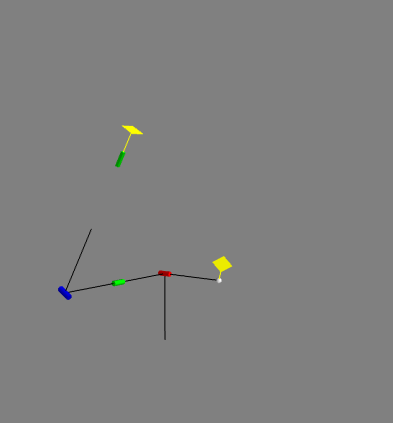

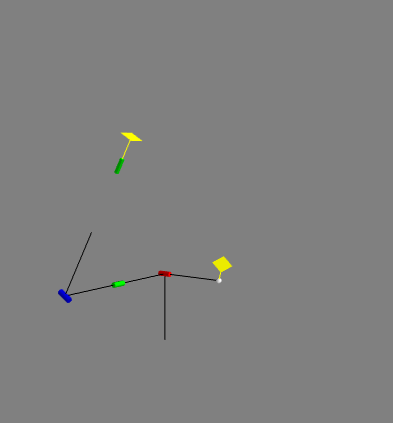

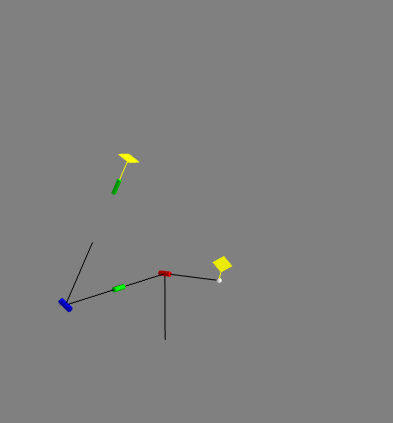

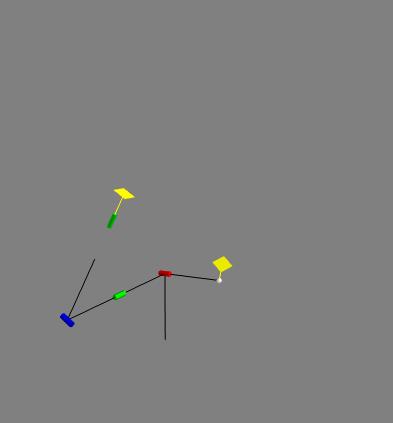

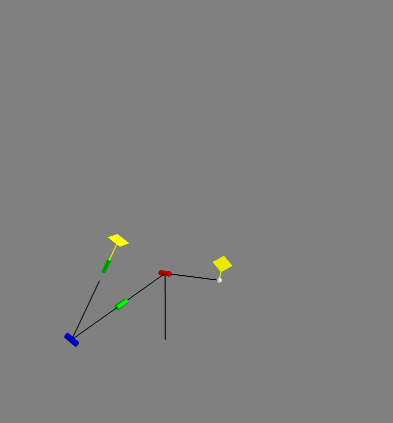

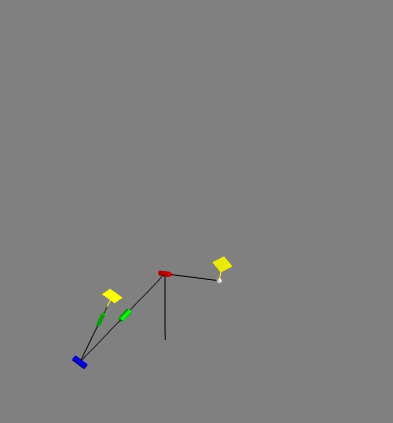

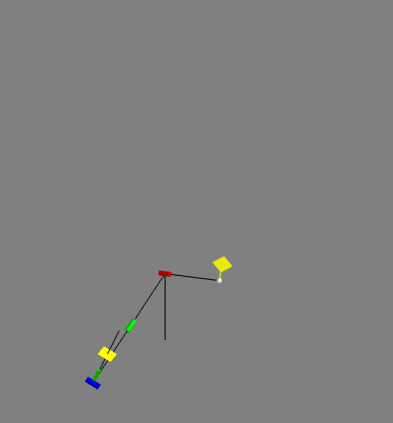

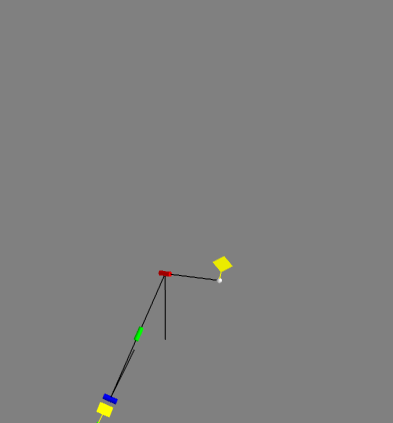

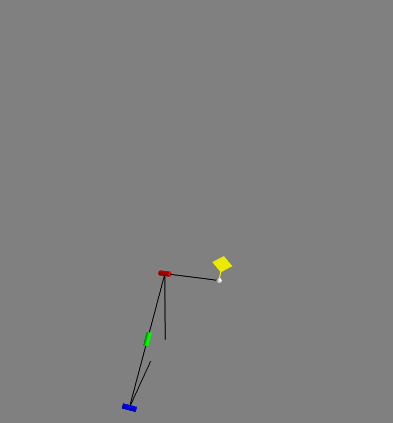

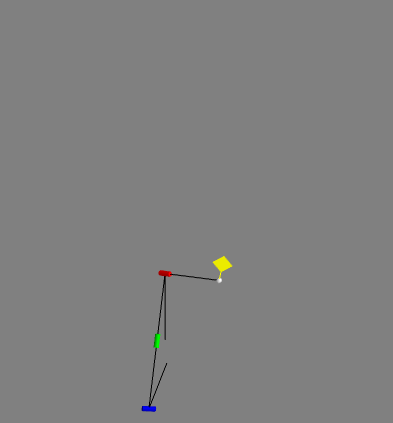

In [15]:
import IPython.display

# display every 10 configuration
step = 10
for mbcIter in mbcList[::step]:
    # a lot of display...
    mbv.display(mb, mbcIter)
    img = display()
    IPython.display.display(img)